In [1]:
# Import Libraries and Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress
import requests
import json
import glob
import os
import geopandas
import plotly
import plotly.figure_factory as ff
import numpy as np
import warnings

from datetime import datetime
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
warnings.filterwarnings('ignore')

# Loading Real Estate Metrics data from Redfin and creating a clean dataset

In [2]:
#url link from - https://www.redfin.com/news/data-center/
#reads in national county level real estate market data
#Duration period: 30

url = 'https://redfin-public-data.s3.us-west-2.amazonaws.com/redfin_market_tracker/county_market_tracker.tsv000.gz'


#assign to dataframe
df = pd.read_csv(url, compression='gzip', sep='\t', on_bad_lines='skip')

print('Num of rows:', len(df))
print('Num of cols:', len(df.columns)) 

#preview data
df.head()

Num of rows: 784430
Num of cols: 58


,period_begin,period_end,period_duration,region_type,region_type_id,table_id,is_seasonally_adjusted,region,city,state,...,sold_above_list_yoy,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks,off_market_in_two_weeks_mom,off_market_in_two_weeks_yoy,parent_metro_region,parent_metro_region_metro_code,last_updated
0,2014-12-01,2014-12-31,30,county,5,2243,f,"Washington County, OH",NaN,Ohio,...,-0.021552,NaN,NaN,NaN,0.000000,-0.055556,0.000000,"Marietta, OH",31930.0,2022-11-20 14:36:43
1,2013-04-01,2013-04-30,30,county,5,3085,f,"Island County, WA",NaN,Washington,...,0.035940,0.177496,0.001771,-0.056232,0.447059,0.027704,0.172549,"Oak Harbor, WA",36020.0,2022-11-20 14:36:43
2,2020-03-01,2020-03-31,30,county,5,730,f,"DeKalb County, IL",NaN,Illinois,...,0.045822,0.200730,0.006931,-0.056696,0.604167,0.044845,0.066352,"Elgin, IL",20994.0,2022-11-20 14:36:43
3,2017-05-01,2017-05-31,30,county,5,2382,f,"Dauphin County, PA",NaN,Pennsylvania,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,"Harrisburg, PA",25420.0,2022-11-20 14:36:43
4,2016-05-01,2016-05-31,30,county,5,996,f,"Warren County, IA",NaN,Iowa,...,0.128527,NaN,NaN,NaN,0.081081,-0.108108,0.081081,"Des Moines, IA",19780.0,2022-11-20 14:36:43


In [3]:
#Filter data and clean-up

#filter real estate dataset on Texas
texas_df = df.loc[df['state'] == 'Texas']

#drop columns we don't need
texas_df.drop(texas_df.columns[[2, 3, 4, 5, 6, 8]], axis=1, inplace=True)

#COUNTY COlUMUN - region column isolate county name
texas_df['county'] = texas_df.apply(lambda x: x['region'].split(',')[0].strip(), axis=1)

#filter texas dataset to counties we are interested in
counties_list = ['Williamson County', 'Travis County', 'Hays County', 'Bastrop County', 'Caldwell County']
texas_counties_df = texas_df.loc[texas_df['county'].isin(counties_list)]

#Creating DATE and YEAR columns  ?? Need to look at with team ??
texas_counties_df['year'] = pd.DatetimeIndex(texas_counties_df['period_end']).year
texas_counties_df['date'] = pd.to_datetime(texas_counties_df['period_end'])
texas_counties_df['month_year'] = texas_counties_df['date'].dt.strftime('%Y-%m')

#preview
print('Num of rows:', len(texas_counties_df))
texas_counties_df.head()

#csv export
#texas_counties_df.to_csv('redfin_texas_counties.csv')


Num of rows: 2573


,period_begin,period_end,region,state,state_code,property_type,property_type_id,median_sale_price,median_sale_price_mom,median_sale_price_yoy,...,off_market_in_two_weeks,off_market_in_two_weeks_mom,off_market_in_two_weeks_yoy,parent_metro_region,parent_metro_region_metro_code,last_updated,county,year,date,month_year
139,2012-01-01,2012-01-31,"Williamson County, TX",Texas,TX,Multi-Family (2-4 Unit),4,152500.0,0.155303,0.270833,...,0.400000,-0.400000,0.066667,"Austin, TX",12420.0,2022-11-20 14:36:43,Williamson County,2012,2012-01-31,2012-01
299,2019-05-01,2019-05-31,"Williamson County, TX",Texas,TX,Condo/Co-op,3,237000.0,0.013904,0.068771,...,0.571429,-0.211180,0.071429,"Austin, TX",12420.0,2022-11-20 14:36:43,Williamson County,2019,2019-05-31,2019-05
474,2019-06-01,2019-06-30,"Williamson County, TX",Texas,TX,Single Family Residential,6,291000.0,-0.029863,-0.017722,...,0.505759,-0.006931,0.056208,"Austin, TX",12420.0,2022-11-20 14:36:43,Williamson County,2019,2019-06-30,2019-06
505,2012-04-01,2012-04-30,"Williamson County, TX",Texas,TX,Multi-Family (2-4 Unit),4,154950.0,0.029568,-0.123090,...,0.571429,0.171429,0.428571,"Austin, TX",12420.0,2022-11-20 14:36:43,Williamson County,2012,2012-04-30,2012-04
1400,2015-08-01,2015-08-31,"Williamson County, TX",Texas,TX,Multi-Family (2-4 Unit),4,219000.0,0.120205,0.084158,...,0.777778,0.215278,0.777778,"Austin, TX",12420.0,2022-11-20 14:36:43,Williamson County,2015,2015-08-31,2015-08


In [4]:
#narrow down dataframe to include only relevant columns
clean_df = texas_counties_df[['period_begin', 'period_end', 'region', 'property_type', 'median_sale_price', 'median_sale_price_mom','median_sale_price_yoy', 'sold_above_list', 'inventory', 'median_dom','date', 'year', 'month_year']]

# ALL RESIDENTIAL Filter
clean_df = clean_df.loc[(clean_df['property_type'] == 'All Residential')]

#Filter on #2018-2022
years = [2018, 2019, 2020, 2021, 2022]
clean_df = clean_df.loc[clean_df['year'].isin(years)]

#format
clean_df['sold_above_list'] = clean_df['sold_above_list'] * 100
clean_df['sold_above_list'] = clean_df['sold_above_list'].round(2)
clean_df['median_sale_price_mom'] = clean_df['median_sale_price_mom'] * 100
clean_df['median_sale_price_mom'] = clean_df['median_sale_price_mom'].round(2)

#sort
clean_df = clean_df.sort_values('date')

#preview
print('Num of rows:', len(clean_df))
clean_df.head()

Num of rows: 290


,period_begin,period_end,region,property_type,median_sale_price,median_sale_price_mom,median_sale_price_yoy,sold_above_list,inventory,median_dom,date,year,month_year
327629,2018-01-01,2018-01-31,"Williamson County, TX",All Residential,266277.5,-6.21,0.004821,18.35,1860.0,54.0,2018-01-31,2018,2018-01
688591,2018-01-01,2018-01-31,"Hays County, TX",All Residential,262000.0,-1.78,0.091667,15.18,767.0,55.0,2018-01-31,2018,2018-01
568557,2018-01-01,2018-01-31,"Bastrop County, TX",All Residential,272000.0,20.35,0.470270,8.93,195.0,52.0,2018-01-31,2018,2018-01
185243,2018-01-01,2018-01-31,"Caldwell County, TX",All Residential,183000.0,-2.53,0.067367,4.35,62.0,45.0,2018-01-31,2018,2018-01
521263,2018-01-01,2018-01-31,"Travis County, TX",All Residential,325505.0,-4.99,0.068982,13.94,3046.0,45.0,2018-01-31,2018,2018-01


# Map of counties we're focusing real estate analysis on

In [5]:
#fips URL
url_fips = 'https://raw.githubusercontent.com/kjhealy/fips-codes/master/county_fips_master.csv'

#assign to dataframe
df_fips = pd.read_csv(url_fips, encoding='ISO-8859-1', on_bad_lines='skip')
tx_fips = df_fips[df_fips['state_abbr'] == 'TX']

#create list add flag column to mark counties we're doing real estate analysis on
county_flag_list = [48453, 48491, 48209,48021, 48055]  #could we use county list from redfin data frame?
tx_fips['county_flag']  = ''

#loop through texas fips dataframe and flag counties we want highlighted.  Populated legend as well. 
for i, row in tx_fips.iterrows():
    if(row['fips'] in county_flag_list):
        tx_fips.at[i,'county_flag'] = row['county_name']


#assign list of fips codes that mark county level boundaries in maps
#Federal Information Processing System (FIPS) Codes for States and Counties 
#FIPS codes are numbers which uniquely identify geographic areas.

fips = tx_fips['fips'].to_list()
values = tx_fips['county_flag'].tolist()

heatmap_color = [
    'rgb(244, 244, 244)',
    'rgb(204, 85, 0)', #Burn Orange
    'rgb(204, 85, 0)',
    'rgb(204, 85, 0)',
    'rgb(204, 85, 0)',
    'rgb(204, 85, 0)']

#endpts = list(range(0,1))

#plotly.figure_factory.create_choropleth
#https://plotly.com/python-api-reference/generated/plotly.figure_factory.create_choropleth.html

fig = ff.create_choropleth(
        fips=fips, values=values,  colorscale = heatmap_color,
        show_state_data = True, scope = ['TX'],
        #binning_endpoints=endpts,
        county_outline={'color': 'rgb(15,15,55)', 'width': 1.5},
	    state_outline={'color': 'rgb(15,15,55)', 'width': 1.5},
        show_hover = True,
	    legend_title='Counties', title='Real Estate Analysis Focus')

hover_ix, hover = [(ix, t) for ix, t in enumerate(fig['data']) if t.text][0]

# fix to show hover data when many counties in a map
# https://github.com/plotly/plotly.py/issues/1429
if len(hover['text']) != len(tx_fips):

    ht = pd.Series(hover['text'])

    no_dupe_ix = ht.index[~ht.duplicated()]

    hover_x_deduped = np.array(hover['x'])[no_dupe_ix]
    hover_y_deduped = np.array(hover['y'])[no_dupe_ix]

    new_hover_x = [x if type(x) == float else x[0] for x in hover_x_deduped]
    new_hover_y = [y if type(y) == float else y[0] for y in hover_y_deduped]

    fig['data'][hover_ix]['text'] = ht.drop_duplicates()
    fig['data'][hover_ix]['x'] = new_hover_x
    fig['data'][hover_ix]['y'] = new_hover_y

fig.layout.template = None
fig.show()

# Loading Fed Rates and creating combined dataframe

In [6]:
# use glob to get all the csv files 
# in the folder
path = os.getcwd()
csv_files = glob.glob(os.path.join(path, "resources/*.csv"))

In [7]:
dict_of_df = {} # initialize empty dictionary

# loop over the list of csv files
for f in csv_files:

    filename = f.split("\\")[-1]

    if (filename[0:3] == 'Fed'):
        print('Location:', f)
        dict_of_df["df_{}".format(filename)] = pd.read_csv(f)
        print('Loaded file:', filename)
    elif (filename[0:3] == 'Mtg'):
        print('Location:', f)
        dict_of_df["df_{}".format(filename)] = pd.read_csv(f)
        print('Loaded file:', filename)

#assign loaded CSVs to dataframes
fedfunds = dict_of_df['df_Fedfunds.csv']
mtg15 = dict_of_df['df_Mtg15.csv']
mtg30 = dict_of_df['df_Mtg30.csv']
mtgfha = dict_of_df['df_MtgFHA.csv']
mtgjumbo = dict_of_df['df_MtgJumbo.csv']

Location: e:\Thins\School\UTAustin Bootcamp\UTA_Project-1\resources\Fedfunds.csv
Loaded file: Fedfunds.csv
Location: e:\Thins\School\UTAustin Bootcamp\UTA_Project-1\resources\Mtg15.csv
Loaded file: Mtg15.csv
Location: e:\Thins\School\UTAustin Bootcamp\UTA_Project-1\resources\Mtg30.csv
Loaded file: Mtg30.csv
Location: e:\Thins\School\UTAustin Bootcamp\UTA_Project-1\resources\MtgFHA.csv
Loaded file: MtgFHA.csv
Location: e:\Thins\School\UTAustin Bootcamp\UTA_Project-1\resources\MtgJumbo.csv
Loaded file: MtgJumbo.csv


In [8]:
#convert DATE field from object to date to faciliate groupby
mtg15['DATE'] = pd.to_datetime(mtg15['DATE'])
mtg30['DATE'] = pd.to_datetime(mtg30['DATE'])
mtgfha['DATE'] = pd.to_datetime(mtgfha['DATE'])
mtgjumbo['DATE'] = pd.to_datetime(mtgjumbo['DATE'])

#compress weekly mortgage rate data into monthly and use the last rate from the month
mtg15 = mtg15.groupby([mtg15['DATE'].dt.strftime('%Y-%m')])['Mtg15'].last().reset_index()
mtg30 = mtg30.groupby([mtg30['DATE'].dt.strftime('%Y-%m')])['Mtg30'].last().reset_index()
mtgfha = mtgfha.groupby([mtgfha['DATE'].dt.strftime('%Y-%m')])['FHA 30'].last().reset_index()
mtgjumbo = mtgjumbo.groupby([mtgjumbo['DATE'].dt.strftime('%Y-%m')])['Jumbo30'].last().reset_index()

#convert DATE field from object to date to facilitate merge
fedfunds['DATE'] = pd.to_datetime(fedfunds['DATE'])
mtg15['DATE'] = pd.to_datetime(mtg15['DATE'])
mtg30['DATE'] = pd.to_datetime(mtg30['DATE'])
mtgfha['DATE'] = pd.to_datetime(mtgfha['DATE'])
mtgjumbo['DATE'] = pd.to_datetime(mtgjumbo['DATE'])

#merge the dataframes
rates_final_df = pd.merge(pd.merge(pd.merge(pd.merge(fedfunds, mtg30, on='DATE'),mtg15, on= 'DATE'),mtgfha, on= 'DATE'),mtgjumbo, on= 'DATE')
rates_final_df = rates_final_df.loc[(rates_final_df['DATE'] >= '2018-01') & (rates_final_df['DATE'] <= '2022-10')]

In [9]:
rates_final_df

,DATE,FED RATES,Mtg30,Mtg15,FHA 30,Jumbo30
1,2018-01-01,1.41,4.15,3.62,4.556,4.428
2,2018-02-01,1.42,4.40,3.85,4.837,4.593
3,2018-03-01,1.51,4.44,3.90,4.788,4.447
4,2018-04-01,1.69,4.58,4.02,4.959,4.648
5,2018-05-01,1.70,4.56,4.06,4.922,4.658
6,2018-06-01,1.82,4.55,4.04,4.96,4.791
7,2018-07-01,1.91,4.54,4.02,4.989,4.688
8,2018-08-01,1.91,4.52,3.97,4.993,4.671
9,2018-09-01,1.95,4.72,4.16,5.086,4.796
10,2018-10-01,2.19,4.86,4.29,5.272,4.91


# Visualization / Analysis of Data

### Sold above listing graphs

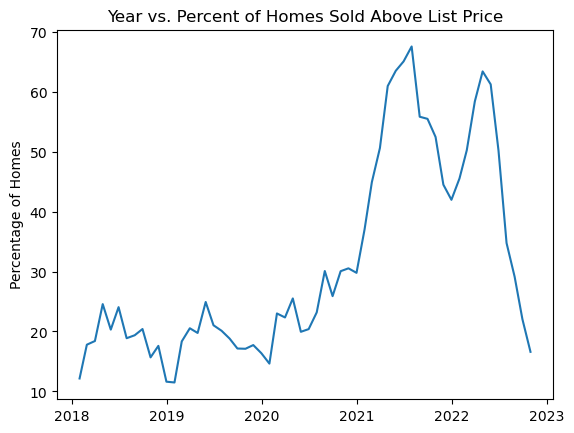

In [10]:
# this one is giving the mean of the counties instead of the sum
above = clean_df.groupby(['date'])['sold_above_list'].mean()
above_df = pd.DataFrame(above)
above_df.reset_index(inplace=True)

plt.plot(above_df['date'], above_df['sold_above_list'])
plt.ylabel('Percentage of Homes')
plt.title('Year vs. Percent of Homes Sold Above List Price')
plt.show()

##I think this is the most accurate of the above graph trials

### DOM graphs

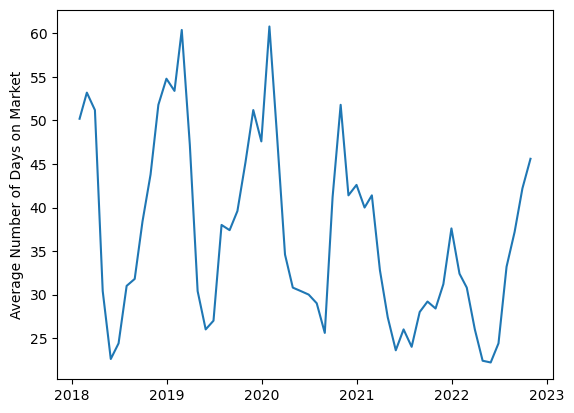

In [11]:
# trying the same with the median sale price
dom = clean_df.groupby(['date'])['median_dom'].mean()
dom_df = pd.DataFrame(dom)
dom_df.reset_index(inplace=True)
dom_df

plt.plot(dom_df['date'], dom_df['median_dom'])
plt.ylabel('Average Number of Days on Market')
plt.show()

### Median Sale Price graphs

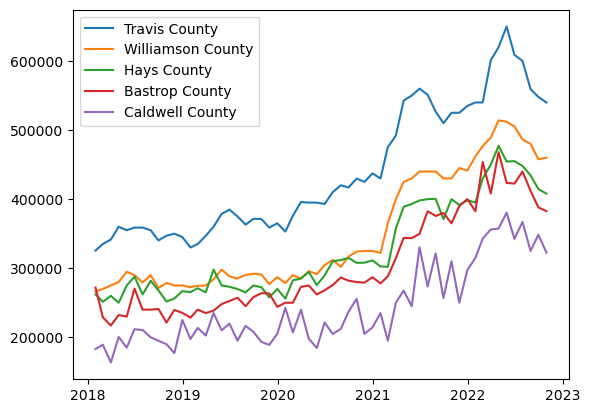

In [12]:
w = clean_df.loc[(clean_df['region'] == 'Williamson County, TX')]
h=clean_df.loc[(clean_df['region'] == 'Hays County, TX')]
b=clean_df.loc[(clean_df['region'] == 'Bastrop County, TX')]
c=clean_df.loc[(clean_df['region'] == 'Caldwell County, TX')]
t=clean_df.loc[(clean_df['region'] == 'Travis County, TX')]
plt.plot(t['date'], t['median_sale_price'], label = 'Travis County')
plt.plot(w['date'], w['median_sale_price'], label = 'Williamson County')
plt.plot(h['date'], h['median_sale_price'], label = 'Hays County')
plt.plot(b['date'], b['median_sale_price'], label = 'Bastrop County')
plt.plot(c['date'], c['median_sale_price'], label = 'Caldwell County')
plt.legend()

plt.show()

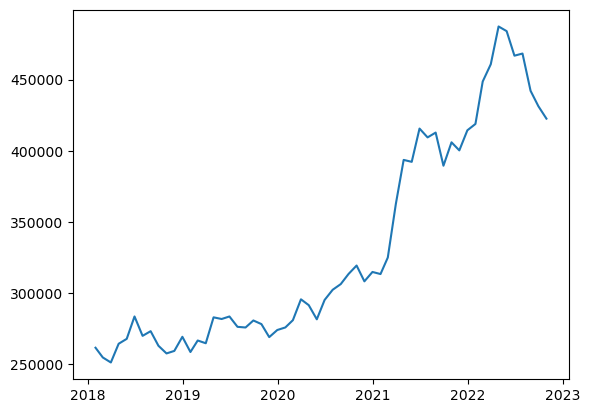

In [13]:
# trying the same with the median sale price
sale_price = clean_df.groupby(['date'])['median_sale_price'].mean()
sale_price_df = pd.DataFrame(sale_price)
sale_price_df.reset_index(inplace=True)
sale_price_df

plt.plot(sale_price_df['date'], sale_price_df['median_sale_price'])
plt.show()


### DOM vs. % sold over listing price

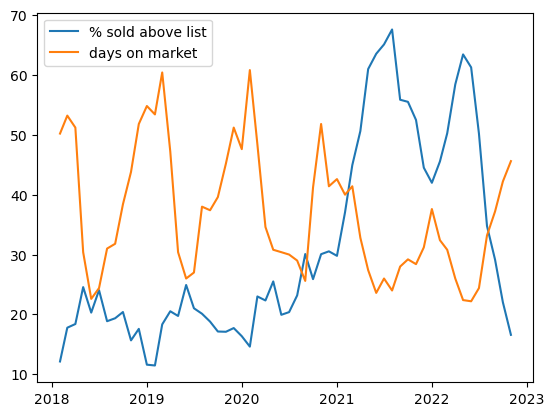

In [14]:
# plotting the percent sold above listing price graph with the median DOM graph to identify possible coorelation
plt.plot(above_df['date'], above_df['sold_above_list'], label='% sold above list')
plt.plot(dom_df['date'], dom_df['median_dom'], label = 'days on market')
plt.legend()
plt.show()

The r-value is: -0.5225123466329074


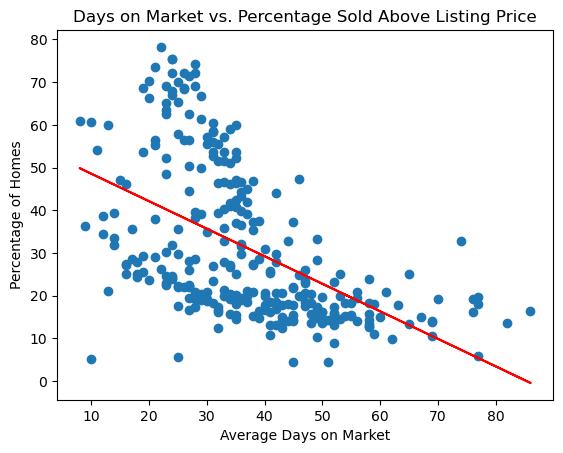

In [15]:
x=clean_df['median_dom']
y=clean_df['sold_above_list']

(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
regress_values = x * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x, y)
plt.plot(x,regress_values,"r-")
#plt.annotate(line_eq, (50,60), fontsize=15,color="red")
plt.xlabel('Average Days on Market')
plt.ylabel('Percentage of Homes')
plt.title('Days on Market vs. Percentage Sold Above Listing Price')
print(f"The r-value is: {rvalue}")
plt.show()

There is a moderate negative coorelation between the number of days on the market and the percentage of homes sold above the listing price. 

In [16]:
combined_df = above_df
combined_df['median_dom'] = dom_df['median_dom']
combined_df['median_sale_price'] = sale_price_df['median_sale_price']
combined_df.describe()

,sold_above_list,median_dom,median_sale_price
count,58.000000,58.000000,58.000000
mean,31.228379,36.889655,331472.139655
std,16.659415,10.536298,73908.239635
min,11.482000,22.200000,251400.000000
25%,18.825500,28.550000,273581.400000
50%,23.622000,33.900000,295531.400000
75%,44.823500,44.850000,404583.825000
max,67.580000,60.800000,487339.000000


### Combine Fed and Mortgage Rates data frame with Real Estate metrics

In [17]:
clean_df.columns

Index(['period_begin', 'period_end', 'region', 'property_type',
       'median_sale_price', 'median_sale_price_mom', 'median_sale_price_yoy',
       'sold_above_list', 'inventory', 'median_dom', 'date', 'year',
       'month_year'],
      dtype='object')

In [18]:
#creating a new DATE column for the sale price yoy DF in order to accurately combine the rates and sale price columns
sale_mom = clean_df.groupby(['month_year'])['median_sale_price_mom'].mean()
sale_mom_df = pd.DataFrame(sale_mom)
sale_mom_df.reset_index(inplace=True)
sale_mom_df["DATE"] = sale_mom_df['month_year']
sale_mom_df["DATE"] = pd.to_datetime(sale_mom_df["DATE"])

sale_mom_df

,month_year,median_sale_price_mom,DATE
0,2018-01,0.968,2018-01-01
1,2018-02,-2.430,2018-02-01
2,2018-03,-2.324,2018-03-01
3,2018-04,6.610,2018-04-01
4,2018-05,1.050,2018-05-01
5,2018-06,7.198,2018-06-01
6,2018-07,-4.886,2018-07-01
7,2018-08,1.084,2018-08-01
8,2018-09,-3.514,2018-09-01
9,2018-10,-2.424,2018-10-01


In [19]:
#combine sales and rates DFs

sales_rates_df = pd.merge(rates_final_df, sale_mom_df, on = 'DATE')
sales_rates_df["month_year"] = pd.to_datetime(sales_rates_df["month_year"])
sales_rates_df

,DATE,FED RATES,Mtg30,Mtg15,FHA 30,Jumbo30,month_year,median_sale_price_mom
0,2018-01-01,1.41,4.15,3.62,4.556,4.428,2018-01-01,0.968
1,2018-02-01,1.42,4.40,3.85,4.837,4.593,2018-02-01,-2.430
2,2018-03-01,1.51,4.44,3.90,4.788,4.447,2018-03-01,-2.324
3,2018-04-01,1.69,4.58,4.02,4.959,4.648,2018-04-01,6.610
4,2018-05-01,1.70,4.56,4.06,4.922,4.658,2018-05-01,1.050
5,2018-06-01,1.82,4.55,4.04,4.96,4.791,2018-06-01,7.198
6,2018-07-01,1.91,4.54,4.02,4.989,4.688,2018-07-01,-4.886
7,2018-08-01,1.91,4.52,3.97,4.993,4.671,2018-08-01,1.084
8,2018-09-01,1.95,4.72,4.16,5.086,4.796,2018-09-01,-3.514
9,2018-10-01,2.19,4.86,4.29,5.272,4.91,2018-10-01,-2.424


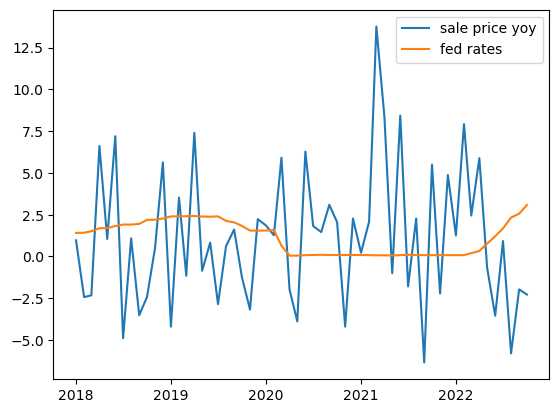

In [20]:
#Trend lines of the median sale price year over year vs the changing fed rates

plt.plot(sales_rates_df['month_year'], sales_rates_df['median_sale_price_mom'], label = 'sale price yoy')
plt.plot(sales_rates_df['month_year'], sales_rates_df['FED RATES'], label = 'fed rates')
plt.legend()
plt.show()

The r-value is: -0.2748054036915873


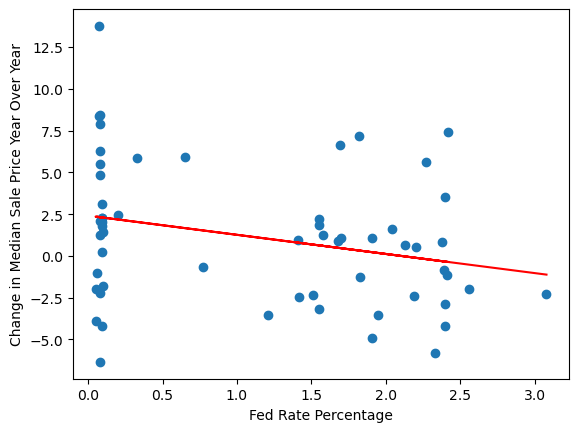

In [21]:
x=sales_rates_df['FED RATES']
y=sales_rates_df['median_sale_price_mom']


(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
regress_values = x * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x, y)
plt.plot(x,regress_values,"r-")
#plt.annotate(line_eq, (0.2,2.5), fontsize=15,color="red")
plt.ylabel('Change in Median Sale Price Year Over Year')
plt.xlabel('Fed Rate Percentage')
#plt.title('')
print(f"The r-value is: {rvalue}")
plt.show()

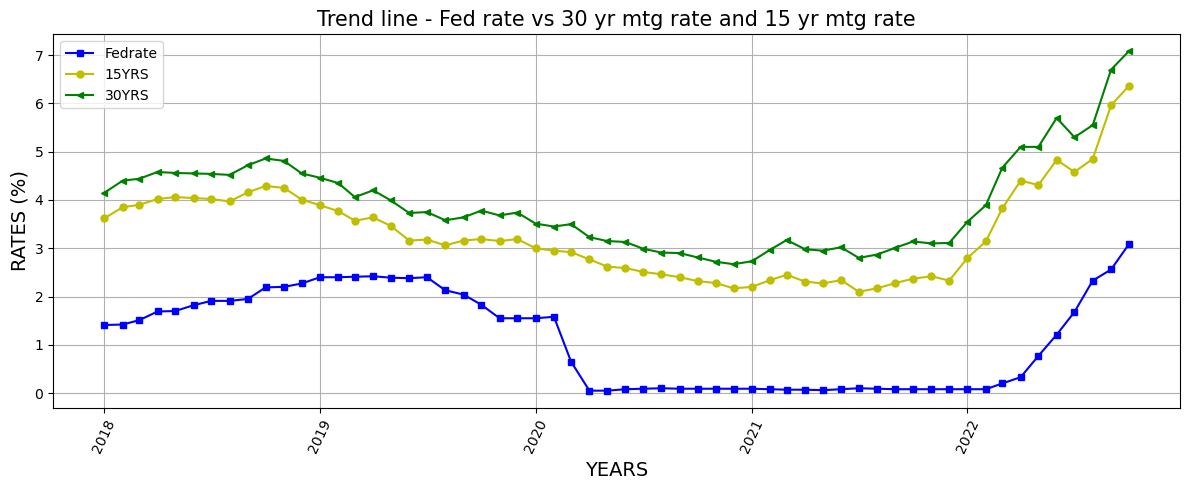

In [22]:
x1 = rates_final_df['DATE']
y1 = rates_final_df['FED RATES']
y2 = rates_final_df['Mtg15']
y3= rates_final_df['Mtg30']


fig1, ax1 = plt.subplots(figsize=(12,5))

plt.plot(x1, y1, markersize=5,marker="s",color="b", label= "Fedrate")
plt.plot(x1, y2, markersize=5,marker="o",color="y", label= "15YRS")
plt.plot(x1, y3, markersize=5,marker="<",color="g", label= "30YRS")

plt.title('Trend line - Fed rate vs 30 yr mtg rate and 15 yr mtg rate',fontsize =15)
plt.xlabel('YEARS',fontsize =14)
plt.ylabel('RATES (%)',fontsize =14)
plt.xticks(rotation = 65)
plt.legend()
plt.grid()

plt.tight_layout()
#plt.savefig('resources/Fedmtg.jpg')
plt.show()


The r-value is: 0.7357863285908708


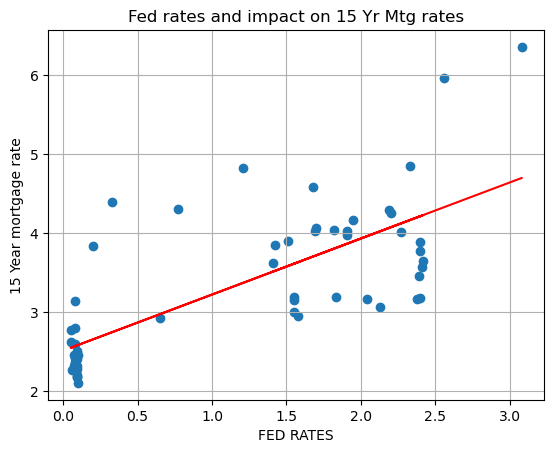

In [23]:

x = rates_final_df['FED RATES']
y = rates_final_df['Mtg15']

(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
regress_values = x * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x, y)
plt.plot(x,regress_values,"r-")
#plt.annotate(line_eq, (50,60), fontsize=15,color="red")
plt.xlabel('FED RATES')
plt.ylabel('15 Year mortgage rate')
plt.title('Fed rates and impact on 15 Yr Mtg rates')
print(f"The r-value is: {rvalue}")
plt.grid()
#plt.savefig('resources/15yrline.jpg')
plt.show()

The r-value is: 0.6918492755188704


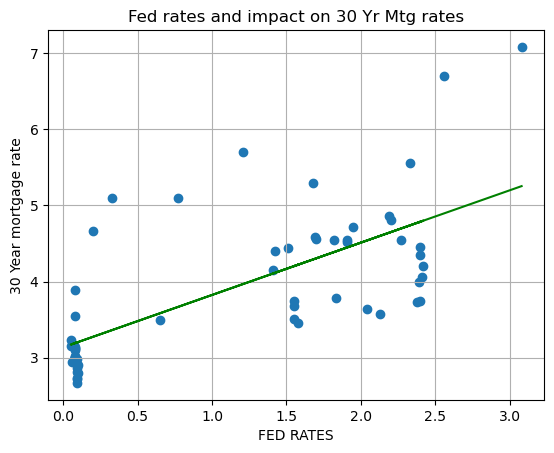

In [24]:
x = rates_final_df['FED RATES']
y = rates_final_df['Mtg30']

(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
regress_values = x * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x, y)
plt.plot(x,regress_values,"g-")
plt.xlabel('FED RATES')
plt.ylabel('30 Year mortgage rate')
plt.title('Fed rates and impact on 30 Yr Mtg rates')
print(f"The r-value is: {rvalue}")
plt.grid()
#plt.savefig('resources/30yr.jpg')
plt.show()


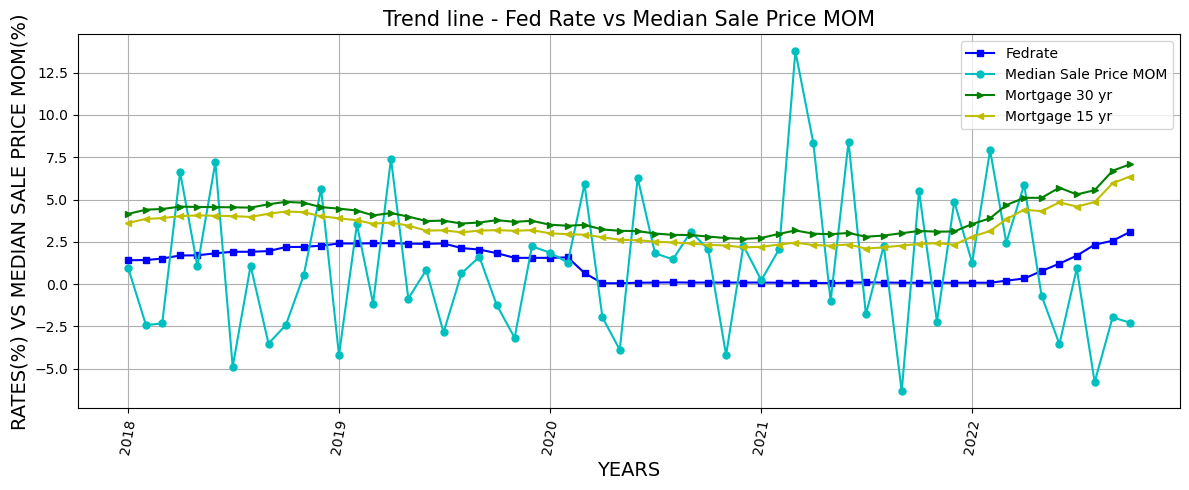

In [25]:
x1 = sales_rates_df['DATE']
y1 = sales_rates_df['FED RATES']
y2 = sales_rates_df['median_sale_price_mom']
y3 = sales_rates_df["Mtg30"]
y4 = sales_rates_df["Mtg15"]



fig1, ax1 = plt.subplots(figsize=(12,5))

plt.plot(x1, y1, markersize=5,marker="s",color="b", label= "Fedrate")
plt.plot(x1, y2, markersize=5,marker="o",color="c", label= "Median Sale Price MOM")
plt.plot(x1, y3, markersize=5,marker=">",color="g", label= "Mortgage 30 yr")
plt.plot(x1, y4, markersize=5,marker="<",color="y", label= "Mortgage 15 yr")


plt.title('Trend line - Fed Rate vs Median Sale Price MOM',fontsize =15)
plt.xlabel('YEARS',fontsize =14)
plt.ylabel('RATES(%) VS MEDIAN SALE PRICE MOM(%)',fontsize =14)
plt.xticks(rotation = 80)
plt.legend()
plt.grid()


plt.tight_layout()
plt.show()

The r-value is: -0.2748054036915873


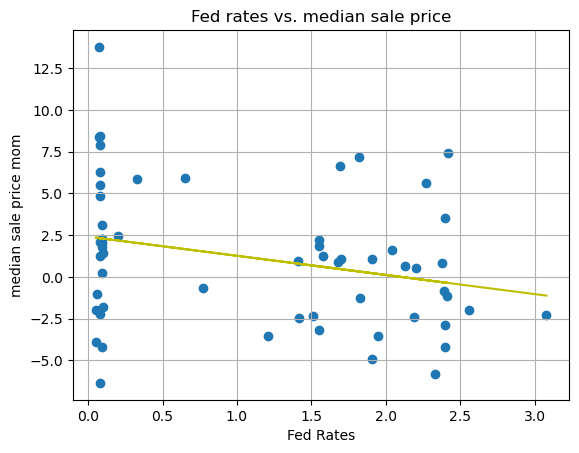

In [26]:
x= sales_rates_df['FED RATES']
y= sales_rates_df['median_sale_price_mom']

(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
regress_values = x * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x, y)
plt.plot(x,regress_values,"y-")

plt.xlabel('Fed Rates')
plt.ylabel('median sale price mom')
plt.title('Fed rates vs. median sale price')
print(f"The r-value is: {rvalue}")
plt.grid()
plt.show()

The r-value is: -0.24781886712434475


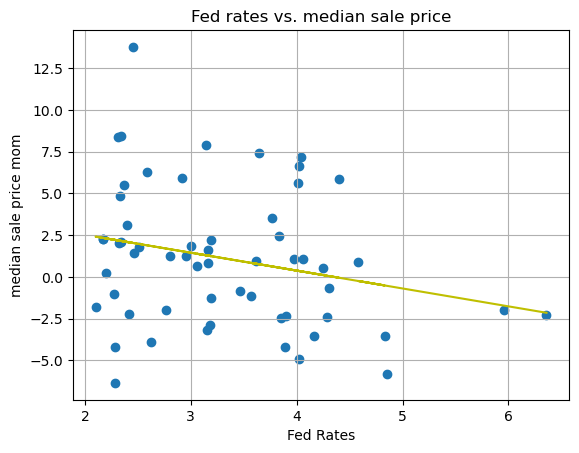

In [27]:
x= sales_rates_df['Mtg15']
y= sales_rates_df['median_sale_price_mom']

(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
regress_values = x * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x, y)
plt.plot(x,regress_values,"y-")

plt.xlabel('Fed Rates')
plt.ylabel('median sale price mom')
plt.title('Fed rates vs. median sale price')
print(f"The r-value is: {rvalue}")
plt.grid()
plt.show()

In [28]:
inventory_df = clean_df.groupby(['month_year'])['inventory'].sum()
inventory_df = pd.DataFrame(inventory_df)
inventory_df.reset_index(inplace=True)
inventory_df["DATE"] = inventory_df['month_year']
inventory_df["DATE"] = pd.to_datetime(inventory_df["DATE"])

inventory = pd.merge(rates_final_df, inventory_df, on = 'DATE')
inventory["month_year"] = pd.to_datetime(inventory["month_year"])
inventory.head()

,DATE,FED RATES,Mtg30,Mtg15,FHA 30,Jumbo30,month_year,inventory
0,2018-01-01,1.41,4.15,3.62,4.556,4.428,2018-01-01,5930.0
1,2018-02-01,1.42,4.40,3.85,4.837,4.593,2018-02-01,6184.0
2,2018-03-01,1.51,4.44,3.90,4.788,4.447,2018-03-01,6867.0
3,2018-04-01,1.69,4.58,4.02,4.959,4.648,2018-04-01,7427.0
4,2018-05-01,1.70,4.56,4.06,4.922,4.658,2018-05-01,8149.0


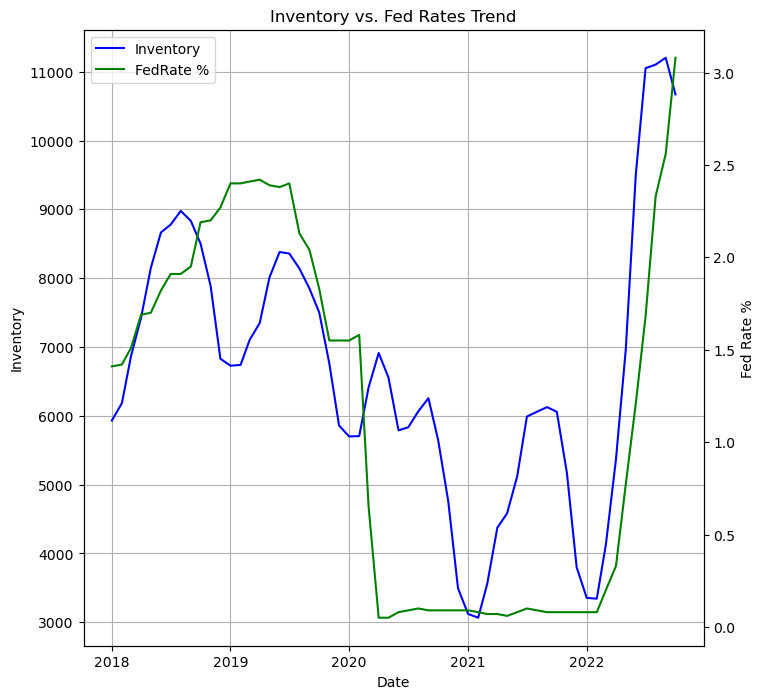

In [29]:
#combine sales and rates DFs
x = inventory['month_year']
y1 = inventory['inventory']
y2 = inventory['FED RATES']


fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()

lns1 = ax1.plot(x, y1, color='b', label='Inventory')
lns2 = ax2.plot(x, y2, color='g', label='FedRate %')

ax1.set_xlabel("Date")
ax1.set_ylabel("Inventory")
ax2.set_ylabel("Fed Rate %")
#ax1.tick_params(axis="y", labelcolor='b')
#ax2.tick_params(axis="y", labelcolor='g')

#legend
lns = lns1 + lns2
labels = [l.get_label() for l in lns] #list compression 
ax1.legend(lns, labels)

ax1.grid()
plt.title('Inventory vs. Fed Rates Trend')
#fig.autofmt_xdate()
plt.show()